In [1]:
## import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import sklearn
from sklearn.decomposition import TruncatedSVD

book = pd.read_csv('e:/data/bx_dump/BX-Books.csv', sep=';', error_bad_lines=False, encoding="latin-1")
book.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']
user = pd.read_csv('E:/data/bx_dump/BX-Users.csv', sep=';', error_bad_lines=False, encoding="latin-1",header=None)
user.columns = ['userID', 'Location', 'Age']
rating = pd.read_csv('E:/data/bx_dump/BX-Book-Ratings.csv', sep=';', error_bad_lines=False, encoding="latin-1")
rating.columns = ['userID', 'ISBN', 'bookRating']

b'Skipping line 6451: expected 8 fields, saw 9\nSkipping line 43666: expected 8 fields, saw 10\nSkipping line 51750: expected 8 fields, saw 9\n'
b'Skipping line 92037: expected 8 fields, saw 9\nSkipping line 104318: expected 8 fields, saw 9\nSkipping line 121767: expected 8 fields, saw 9\n'
b'Skipping line 144057: expected 8 fields, saw 9\nSkipping line 150788: expected 8 fields, saw 9\nSkipping line 157127: expected 8 fields, saw 9\nSkipping line 180188: expected 8 fields, saw 9\nSkipping line 185737: expected 8 fields, saw 9\n'
b'Skipping line 209387: expected 8 fields, saw 9\nSkipping line 220625: expected 8 fields, saw 9\nSkipping line 227932: expected 8 fields, saw 11\nSkipping line 228956: expected 8 fields, saw 10\nSkipping line 245932: expected 8 fields, saw 9\nSkipping line 251295: expected 8 fields, saw 9\nSkipping line 259940: expected 8 fields, saw 9\nSkipping line 261528: expected 8 fields, saw 9\n'
D:\ProgramData\Anaconda3\envs\normal\lib\site-packages\IPython\core\intera

In [2]:
rating.head()

,userID,ISBN,bookRating
0,276726,0155061224,5
1,276727,0446520802,0
2,276729,052165615X,3
3,276729,0521795028,6
4,276733,2080674722,0


In [3]:
user.head()

,userID,Location,Age
0,1,"nyc, new york, usa",\N
1,2,"stockton, california, usa",18
2,3,"moscow, yukon territory, russia",\N
3,4,"porto, v.n.gaia, portugal",17
4,5,"farnborough, hants, united kingdom",\N


In [4]:
book.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
1,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
2,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
3,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
4,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...,http://images.amazon.com/images/P/0399135782.0...


In [5]:
combine_book_rating = pd.merge(rating, book, on='ISBN')
columns = ['yearOfPublication', 'publisher', 'bookAuthor', 'imageUrlS', 'imageUrlM', 'imageUrlL']
combine_book_rating = combine_book_rating.drop(columns, axis=1)
combine_book_rating.head()

,userID,ISBN,bookRating,bookTitle
0,276726,0155061224,5,Rites of Passage
1,159181,0155061224,0,Rites of Passage
2,276727,0446520802,0,The Notebook
3,278418,0446520802,0,The Notebook
4,638,0446520802,0,The Notebook


### Filter to only popular books

Remove rows where book title is missing

In [6]:
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['bookTitle'])

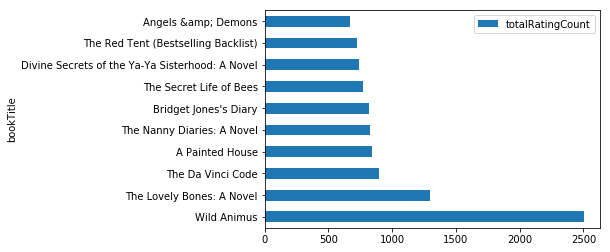

In [11]:
book_ratingCount = (combine_book_rating.
     groupby(by = ['bookTitle'])['bookRating'].
     count().
     reset_index().
     rename(columns = {'bookRating': 'totalRatingCount'})
     [['bookTitle', 'totalRatingCount']]
    )
book_ratingCount_ = book_ratingCount.sort_values(by='totalRatingCount',ascending=False)
book_ratingCount_[:10].plot(kind='barh',x=book_ratingCount_['bookTitle'][:10])

#### Now we can merge the total rating count data into the rating data, giving us exactly what we need to filter out the lesser known books.

In [12]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'bookTitle', right_on = 'bookTitle', how = 'left')
rating_with_totalRatingCount.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
0,276726,0155061224,5,Rites of Passage,14
1,159181,0155061224,0,Rites of Passage,14
2,276727,0446520802,0,The Notebook,650
3,278418,0446520802,0,The Notebook,650
4,638,0446520802,0,The Notebook,650


In [13]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(book_ratingCount['totalRatingCount'].describe())

count   241071.000
mean         4.277
std         16.739
min          1.000
25%          1.000
50%          1.000
75%          3.000
max       2502.000
Name: totalRatingCount, dtype: float64


#### The median book has only been rated one time. Let’s take a look at the top of the distribution.

In [15]:
book_ratingCount['totalRatingCount'].quantile(np.arange(.9, 1, 0.005))

0.900    7.000
0.905    7.000
0.910    8.000
0.915    8.000
0.920    9.000
0.925    9.000
0.930   10.000
0.935   10.000
0.940   11.000
0.945   12.000
0.950   13.000
0.955   14.000
0.960   16.000
0.965   18.000
0.970   20.000
0.975   24.000
0.980   29.000
0.985   36.000
0.990   50.000
0.995   83.000
Name: totalRatingCount, dtype: float64

#### So about 1% of books have 50 ratings, 2% have 29 ratings. Since we have so many books in our data, we’ll limit it to the top 1%, this will give us 2713 different books. 

In [18]:
popularity_threshold = 50
rating_popular_book = rating_with_totalRatingCount[rating_with_totalRatingCount.totalRatingCount >= popularity_threshold]
rating_popular_book.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount
2,276727,0446520802,0,The Notebook,650
3,278418,0446520802,0,The Notebook,650
4,638,0446520802,0,The Notebook,650
5,3363,0446520802,0,The Notebook,650
6,7158,0446520802,10,The Notebook,650


#### Filtering to US users only

In [19]:
combined = rating_popular_book.merge(user, left_on = 'userID', right_on = 'userID', how = 'left')

us_canada_user_rating = combined[combined['Location'].str.contains("usa|canada")]
us_canada_user_rating=us_canada_user_rating.drop('Age', axis=1)
us_canada_user_rating.head()

,userID,ISBN,bookRating,bookTitle,totalRatingCount,Location
1,278418,0446520802,0,The Notebook,650,"omaha, nebraska, usa"
2,638,0446520802,0,The Notebook,650,"san diego, california, usa"
3,3363,0446520802,0,The Notebook,650,"knoxville, tennessee, usa"
4,7158,0446520802,10,The Notebook,650,"omaha, nebraska, usa"
5,8253,0446520802,10,The Notebook,650,"tulsa, oklahoma, usa"


In [41]:
if not us_canada_user_rating[us_canada_user_rating.duplicated(['userID', 'bookTitle'])].empty:
    initial_rows = us_canada_user_rating.shape[0]

    print('Initial dataframe shape {0}'.format(us_canada_user_rating.shape))
    us_canada_user_rating = us_canada_user_rating.drop_duplicates(['userID', 'bookTitle'])
    current_rows = us_canada_user_rating.shape[0]
    print('New dataframe shape {0}'.format(us_canada_user_rating.shape))
    print('Removed {0} rows'.format(initial_rows - current_rows))

Initial dataframe shape (251614, 6)
New dataframe shape (248948, 6)
Removed 2666 rows


In [42]:
us_canada_user_rating_pivot = us_canada_user_rating.pivot(index = 'bookTitle', columns = 'userID', values = 'bookRating').fillna(0)
us_canada_user_rating_matrix = csr_matrix(us_canada_user_rating_pivot.values)

In [46]:
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(us_canada_user_rating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [47]:
us_canada_user_rating_pivot.shape

(2442, 40016)

In [140]:
us_canada_book_title = us_canada_user_rating_pivot2.columns
us_canada_book_list = list(us_canada_book_title)
query_index = us_canada_book_list.index("The Green Mile: Coffey's Hands (Green Mile Series)")

distances, indices = model_knn.kneighbors(us_canada_user_rating_pivot.iloc[query_index, :].reshape(1, -1), n_neighbors = 6)

for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(us_canada_user_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, us_canada_user_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for The Green Mile: Coffey's Hands (Green Mile Series):

1: The Green Mile: Night Journey (Green Mile Series), with distance of 0.26063737394209996:
2: The Green Mile: The Mouse on the Mile (Green Mile Series), with distance of 0.2911623754404248:
3: The Green Mile: The Bad Death of Eduard Delacroix (Green Mile Series), with distance of 0.2959542871302775:
4: The Two Dead Girls (Green Mile Series), with distance of 0.30596709534565514:
5: The Green Mile: Coffey on the Mile (Green Mile Series), with distance of 0.37646848777592923:


D:\ProgramData\Anaconda3\envs\normal\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


In [139]:
us_canada_user_rating_pivot2 = us_canada_user_rating.pivot(index = 'userID', columns = 'bookTitle', values = 'bookRating').fillna(0)

In [114]:
us_canada_user_rating_pivot2.head()

bookTitle,10 Lb. Penalty,16 Lighthouse Road,1984,1st to Die: A Novel,2010: Odyssey Two,204 Rosewood Lane,2061: Odyssey Three,24 Hours,2nd Chance,3rd Degree,...,YOU BELONG TO ME,Year of Wonders,You Belong To Me,You Shall Know Our Velocity,Young Wives,Zen and the Art of Motorcycle Maintenance: An Inquiry into Values,Zoya,"\O\"" Is for Outlaw""","\Surely You're Joking, Mr. Feynman!\"": Adventures of a Curious Character""",stardust
userID,,,,,,,,,,,,,,,,,,,,,
8,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
9,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
14,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
16,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
17,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [115]:
us_canada_user_rating_pivot2.shape

(40016, 2442)

In [118]:
X = us_canada_user_rating_pivot2.values.T
X.shape

(2442, 40016)

In [119]:
import sklearn
from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components=12, random_state=17)
matrix = SVD.fit_transform(X)
matrix.shape

(2442, 12)

In [121]:
import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)
corr = np.corrcoef(matrix)
corr.shape

(2442, 2442)

In [123]:
us_canada_book_title = us_canada_user_rating_pivot2.columns
us_canada_book_list = list(us_canada_book_title)
coffey_hands = us_canada_book_list.index("The Green Mile: Coffey's Hands (Green Mile Series)")
print(coffey_hands)

1906


In [131]:
corr_coffey_hands  = corr[coffey_hands]
corr_coffey_hands

array([0.17205447, 0.13013973, 0.46594724, ..., 0.64677237, 0.06944998,
       0.02217753])

In [125]:
list(us_canada_book_title[(corr_coffey_hands<1.0) & (corr_coffey_hands>0.9)])

['Cold Fire',
 'Desperation',
 'Needful Things',
 'Rose Madder',
 'The Bachman Books: Rage, the Long Walk, Roadwork, the Running Man',
 'The Dark Half',
 'The Dead Zone',
 'The Green Mile: Coffey on the Mile (Green Mile Series)',
 'The Green Mile: Night Journey (Green Mile Series)',
 'The Green Mile: The Bad Death of Eduard Delacroix (Green Mile Series)',
 'The Green Mile: The Mouse on the Mile (Green Mile Series)',
 'The Shining',
 'The Two Dead Girls (Green Mile Series)']

The results look great!